In [10]:
import pandas as pd
import networkx as nx
import community as community_louvain
import community.community_louvain as community_louvain

# Sample data
data = {
    'Client ID': [1001, 1002, 1003, 1004],
    'Transaction Amount': [50.35, 100.20, 75.10, 500.75],
    'Location': ['New York', 'Los Angeles', 'Miami', 'San Francisco'],
    'Transaction Date': ['2023-07-12', '2023-07-10', '2023-07-09', '2023-07-08']
}

# Create DataFrame
df = pd.DataFrame(data)
df

,Client ID,Transaction Amount,Location,Transaction Date
0,1001,50.35,New York,2023-07-12
1,1002,100.20,Los Angeles,2023-07-10
2,1003,75.10,Miami,2023-07-09
3,1004,500.75,San Francisco,2023-07-08


In [11]:
# Convert 'Transaction Date' to datetime
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])

In [12]:
# Construct the graph
G = nx.Graph()

In [14]:
G

In [15]:
# Add nodes (clients) to the graph
G.add_nodes_from(df['Client ID'])

In [16]:
# Add edges (transactions) between clients based on the same location and date
for i, row1 in df.iterrows():
    for j, row2 in df.iterrows():
        if i != j and row1['Location'] == row2['Location'] and row1['Transaction Date'] == row2['Transaction Date']:
            G.add_edge(row1['Client ID'], row2['Client ID'])

In [18]:
df

,Client ID,Transaction Amount,Location,Transaction Date
0,1001,50.35,New York,2023-07-12
1,1002,100.20,Los Angeles,2023-07-10
2,1003,75.10,Miami,2023-07-09
3,1004,500.75,San Francisco,2023-07-08


In [21]:
# Detect communities using the Louvain algorithm
communities = community_louvain.best_partition(G)
communities

{1001: 0, 1002: 1, 1003: 2, 1004: 3}

In [22]:
# Assign community labels to the DataFrame
df['Community'] = df['Client ID'].map(communities)
df

,Client ID,Transaction Amount,Location,Transaction Date,Community
0,1001,50.35,New York,2023-07-12,0
1,1002,100.20,Los Angeles,2023-07-10,1
2,1003,75.10,Miami,2023-07-09,2
3,1004,500.75,San Francisco,2023-07-08,3


In [29]:
# Calculate community statistics
community_stats = df.groupby('Community').agg({
    'Transaction Amount': ['mean', 'std', 'count']
}).reset_index()

community_stats

Community Transaction Amount          
                          mean std count
0         0              50.35 NaN     1
1         1             100.20 NaN     1
2         2              75.10 NaN     1
3         3             500.75 NaN     1

In [24]:
# Detect anomalies within each community
anomalies = []
for i, row in df.iterrows():
    community_mean = community_stats.loc[community_stats['Community'] == row['Community'], ('Transaction Amount', 'mean')].values[0]
    community_std = community_stats.loc[community_stats['Community'] == row['Community'], ('Transaction Amount', 'std')].values[0]
    if abs(row['Transaction Amount'] - community_mean) > 2 * community_std:  # Customize threshold for anomaly detection
        anomalies.append(row['Client ID'])

In [25]:
# Display detected anomalies
print("Detected Anomalies:")
print(df[df['Client ID'].isin(anomalies)][['Client ID', 'Transaction Amount', 'Location', 'Transaction Date', 'Community']])


Detected Anomalies:
Empty DataFrame
Columns: [Client ID, Transaction Amount, Location, Transaction Date, Community]
Index: []


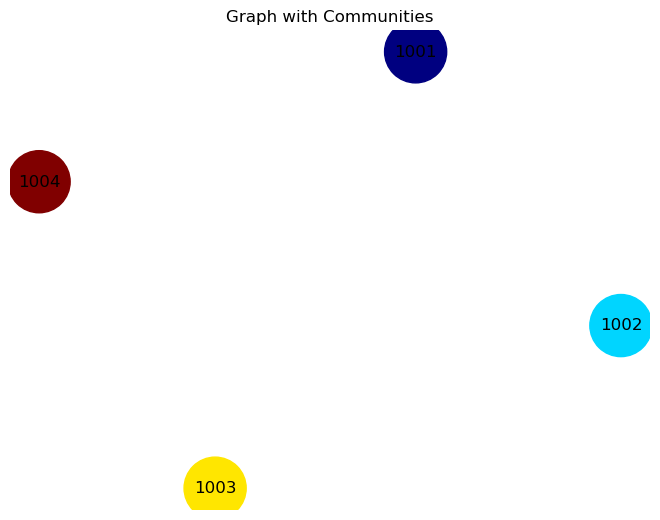

In [28]:
# Draw the graph with nodes colored based on their community memberships
pos = nx.spring_layout(G, seed=42)  # Layout for node positions
node_colors = [communities[node] for node in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.jet, with_labels=True, node_size=2000)
plt.title('Graph with Communities')
plt.show()
